# 

# 1. Data
In this ipynb file, we will do the following:
1. Data Cleaning/Processing for WSB reddit posts
2. Check token count for the data
3. Set up for prodigy annotation
4. Gather the annotated data from Prodigy
5. Make a wordcloud


## Data Cleaning/Processing for WSB reddit posts

In [7]:
# Import necessary packages
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import emoji
import nltk
import json


In [9]:
# Read data
data = pd.read_csv('reddit_wsb.csv')

# View first 5 rows
data.head(5)


,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [10]:
# Remove columns that are not needed
data = data[['title', 'body', 'created']]

# Combine title and body
data['text'] = data['title'] + " " + data['body'].fillna('')

data = data[['text', 'created']]

#View first 5 rows
pd.set_option('display.max_colwidth', 100)
data.head(5)


,text,created
0,"It's not about the money, it's about sending a message. 🚀💎🙌",1.611863e+09
1,Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts,1.611862e+09
2,Exit the system The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibr...,1.611862e+09
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETARDED THAN ME PLEASE INTERPRET?,1.611862e+09
4,"Not to distract from GME, just thought our AMC brothers should be aware of this",1.611862e+09


### Data Cleaning

In [11]:
def clean_wsb_text(text, max_tokens=512):
    """
    Cleans and preprocesses WSB posts.
    
    """

    # Step 1: Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Step 2: Lowercase everything
    text = text.lower()

    # Step 3: Remove Reddit-specific formatting (e.g., *, ^, `)
    text = re.sub(r"\*|\^|`", "", text)

    # Step 4: Preserve stock symbols (i.e. $GME)
    text = re.sub(r"\$\w+", lambda x: x.group(0).upper(), text)

    # Step 5: Replace emojis with text equivalent
    text = emoji.demojize(text, delimiters=("", ""))

    # Step 6: Cap Punctuation to 3 or less
    text = re.sub(r"([!?])\1{3,}", r"\1\1\1", text)

    # Step 7: Remove non-alphanumeric characters (except relevant ones)
    text = re.sub(r"[^a-zA-Z0-9\s\$#!?]", "", text)

    # Step 8: Truncate to the maximum number of tokens
    text = " ".join(text.split()[:max_tokens])

    return text

In [12]:
# Apply cleaning function to the data
data['text_cleaned'] = data['text'].apply(clean_wsb_text)

#View first 5 rows
data.head(5)


,text,created,text_cleaned
0,"It's not about the money, it's about sending a message. 🚀💎🙌",1.611863e+09,its not about the money its about sending a message rocketgemstoneraisinghands
1,Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts,1.611862e+09,math professor scott steiner says the numbers spell disaster for gamestop shorts
2,Exit the system The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibr...,1.611862e+09,exit the system the ceo of nasdaq pushed to halt trading to give investors a chance to recalibra...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETARDED THAN ME PLEASE INTERPRET?,1.611862e+09,new sec filing for gme! can someone less retarded than me please interpret?
4,"Not to distract from GME, just thought our AMC brothers should be aware of this",1.611862e+09,not to distract from gme just thought our amc brothers should be aware of this


In [34]:
# Export to CSV
data.to_csv('reddit_wsb_cleaned.csv', index=False)


## Check token count for the data



95th percentile: 524.70


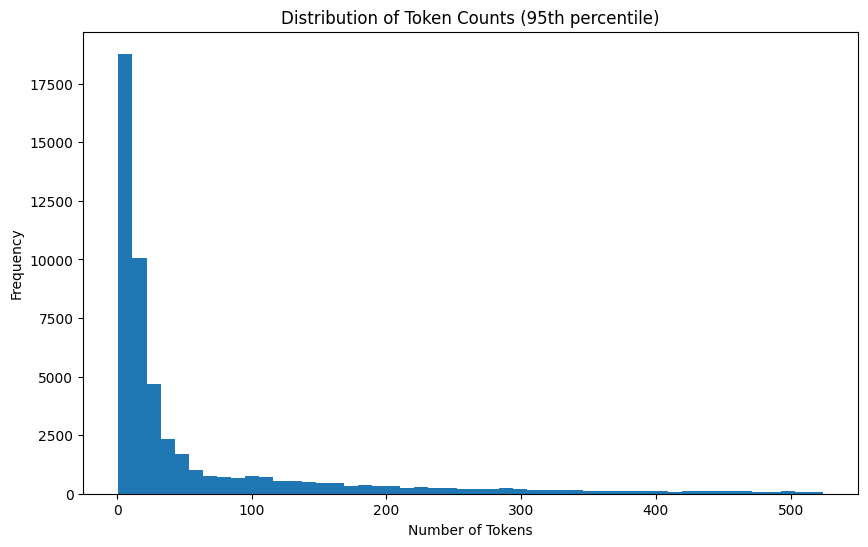

In [14]:
# Calculate token counts
token_counts = data['text'].str.split().str.len()

# Basic statistics
print(f"95th percentile: {token_counts.quantile(0.95):.2f}")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(token_counts[token_counts < token_counts.quantile(0.95)], bins=50)
plt.title('Distribution of Token Counts (95th percentile)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

## Set up for Prodigy (2000 samples)

In [15]:
# Read the previous data
df = pd.read_csv('reddit_wsb_cleaned.csv').text_cleaned

# Ensure text column exists
if isinstance(df, pd.Series):
    df = df.to_frame(name="text")

# Sample 2,000 rows
sampled_df = df.sample(n=2000, random_state=42)

# Convert to Prodigy format
prodigy_data = [{"text": text} for text in sampled_df["text"]]

# Save to JSONL format for Prodigy
with open("prodigy_input.jsonl", "w") as f:
    for entry in prodigy_data:
        f.write(json.dumps(entry) + "\n")

print("Subset saved for Prodigy!")


Subset saved for Prodigy!


## Gather the annotated data from Prodigy

In [17]:
# Load the Prodigy JSONL file
with open("Prodigy/labeled_data.jsonl", "r") as f:
    data = [json.loads(line) for line in f]
    
    
# Convert to DataFrame with error handling
df_prodigy = pd.DataFrame({
    "text": [item["text"] for item in data],
    "sentiment_label": [item.get("accept", [None])[0] if item.get("accept") else None for item in data]
})

# Map labels to numeric values
label_mapping = {"positive": 2, "neutral": 1, "negative": 0}
df_prodigy["sentiment_label"] = df_prodigy["sentiment_label"].map(label_mapping)

# Drop rows with NaN in the sentiment_label column
df_prodigy = df_prodigy.dropna(subset=["sentiment_label"])

# Convert labels to integers
df_prodigy["sentiment_label"] = df_prodigy["sentiment_label"].astype(int)

df_prodigy

,text,sentiment_label
1,trading 212 wont give this retard an account says try later been like that all day they obvs don...,0
2,theyre saying we throttled but were higher avg than yesterday?? makes no sense gme rocketrocket,0
4,weed bet im holding for the next few months $ACB has been a dog but is poised for a comeback wai...,2
5,fuvk you all,0
6,cashapp jusr let me buy the fucking amc dip its the only one left buy like your life depends on ...,1
...,...,...
1985,jcpenny cpprq fuddy duddy store memes?,1
1986,do not sell weve always said no spiralnotepadwavinghandmediumlightskintone so dont start now im ...,2
1987,i dont have much to play with but im with you fellow retards to the moon rocketrocketrocket,2
1989,during a gold rush sell shovels michael scott,1


In [19]:
# Save the cleaned dataset
df_prodigy.to_csv("cleaned_labeled_data.csv", index=False)


### Remove Annotated Data from Original Data

In [41]:
# Load the original cleaned dataset
original_data = pd.read_csv("reddit_wsb_cleaned.csv")

# Create mask for rows that are not in the annotated data
mask = ~original_data["text_cleaned"].isin(df_prodigy["text"].values)

# Apply mask to get unlabeled data
cleaned_unlabeled = original_data[mask]

# Reset the index before saving
cleaned_unlabeled = cleaned_unlabeled.reset_index(drop=True)

# Save the cleaned dataset (only unlabeled data)
cleaned_unlabeled.to_csv("cleaned_unlabeled.csv", index=False)
print(f"Original data size: {len(original_data)}")
print(f"Annotated data size: {len(df_prodigy)}")
print(f"Remaining unlabeled data size: {len(cleaned_unlabeled)}")

Original data size: 53187
Annotated data size: 1781
Remaining unlabeled data size: 51216


## WordCloud

In [23]:
# Read the CSV file
df = pd.read_csv('cleaned_unlabeled.csv')

# Combine all text into one string
text = ' '.join(df['text'].astype(str))

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
#plt.figure(figsize=(20,10))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.show()
